# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from ResNet import ResnetBuilder # ResNet.py
import json
import itertools
import gc
import glob
from IPython.display import clear_output

# 2. Data Processing

## 2.1 Load Data

In [2]:
# 元データはCSV．各列がピクセルの位置を示しており各行が個々のデータを表す．
train = pd.read_csv("./data/train.csv") # trainのみ1列目にラベル(0-9)が与えられている
test = pd.read_csv("./data/test.csv")

# 画像サイズ
img_size_x = 28
img_size_y = 28
channels = 1

# trainラベル
label_num = np.array(train.label) # 0-9
label = pd.get_dummies(label_num).values # one-hot encoding
class_names = np.unique(label_num).astype("str") # クラス名 "0"-"9"
n_classes = len(np.unique(label_num)) # クラス数　=　10

# trainからラベル列を削除
train = train.drop(labels = ["label"], axis = 1) 

## 2.2 Preprocess

In [3]:
# 平均０，分散１となるように各データを正規化
train = scale(train, axis=1)
test = scale(test, axis=1)

# 元データを入力形状(データ数*28*28*1)に変換
train = train.reshape(-1,28,28,1).astype('float32')
test = test.reshape(-1,28,28,1).astype('float32')

C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


## 2.3 Show Image Sample

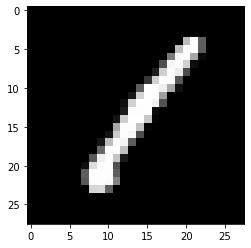

In [4]:
plt.figure()
plt.imshow(train[0,:,:,0], cmap='gray')
plt.show()

# 3. Model Summary

## 3.1 Structure

In [6]:
inputShape=(img_size_x, img_size_y, channels)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50モデル
ResNetModel.summary()
clear_session()
del ResNetModel
gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

102835

## 3.2 Result Setting

In [4]:
# modelのバージョン毎に結果保存用のフォルダを作成
model_name = "ResNet50_epoch10_batch64_ensemble" # 設定に変更があった場合ここだけ変更 ensemble
csv_dir = "./Result/"+model_name 
conf_dir = csv_dir+"/CM_result" # 混合行列画像保存用のサブフォルダ
model_dir = csv_dir+"/model_dir"

# 新規にフォルダを作成する関数．同名のフォルダがすでに存在する場合は削除して作り直す
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)
        
# 結果保存用フォルダの作成
my_makedirs(csv_dir)
my_makedirs(conf_dir)
my_makedirs(model_dir)

# 4. Evaluate Model

## 4.1 Training Setting

In [5]:
# 学習の設定
inputShape=(img_size_x, img_size_y, channels)
batch_size = 64 # 32, 64, 128, 256, 512(first), 1024, 2048など調整
n_epoch = 10 # エポック数
learning_rate = 0.001 #0.003
early_stopping_patience = 300 # 性能向上がない場合，学習を早期終了するエポック数
sp = 10 # 交差検証の分割数

# 評価指標の設定(accuracy, 各クラスのprecision, recall, fscoreとそれらの平均)
predict = np.empty([len(label), n_classes])
predict_label = np.empty([len(label), n_classes])
acc_list = np.empty([sp,1])
precision_list = np.empty([sp, n_classes])
recall_list = np.empty([sp, n_classes])
fscore_list = np.empty([sp, n_classes])
avg_precision = np.empty([sp,1])
avg_recall = np.empty([sp,1])
avg_fscore = np.empty([sp,1])

## 4.2 Training and Validation (10-fold cross validation)

### 4.2.1 Each fold iteration

Iteration No. 1

Train on 37794 samples, validate on 4206 samples
Epoch 1/10
37760/37794 [============================>.] - ETA: 0s - loss: 4.3093 - acc: 0.9557
Epoch 00001: val_loss improved from inf to 3.57545, saving model to img_classifier_model_1_ResNet50_epoch10_batch64_ensemble.h5
37794/37794 [==============================] - 46s 1ms/sample - loss: 4.3090 - acc: 0.9557 - val_loss: 3.5754 - val_acc: 0.9810
Epoch 2/10
37760/37794 [============================>.] - ETA: 0s - loss: 3.1979 - acc: 0.9922
Epoch 00002: val_loss improved from 3.57545 to 2.95338, saving model to img_classifier_model_1_ResNet50_epoch10_batch64_ensemble.h5
37794/37794 [==============================] - 35s 920us/sample - loss: 3.1977 - acc: 0.9921 - val_loss: 2.9534 - val_acc: 0.9788
Epoch 3/10
37760/37794 [============================>.] - ETA: 0s - loss: 2.6972 - acc: 0.9972
Epoch 00003: val_loss improved from 2.95338 to 2.55706, saving model to img_classifier_model_1_ResNet50_epoch10_batch64_ensemble.h5

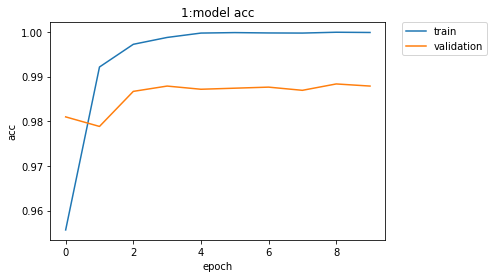

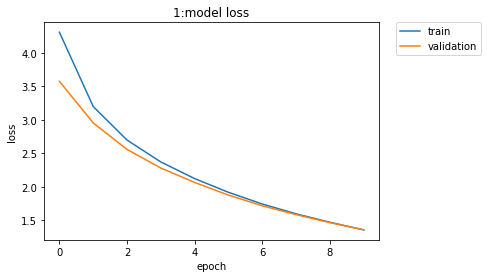

Done compiling best model.


1. Accuracy on validation data: 0.987874
Classification Report
              precision    recall  f1-score   support

           0    0.99515   0.99034   0.99274       414
           1    1.00000   0.99787   0.99893       469
           2    0.98810   0.99282   0.99045       418
           3    0.98848   0.98394   0.98621       436
           4    0.97349   0.99020   0.98177       408
           5    0.98429   0.98947   0.98688       380
           6    0.99275   0.99275   0.99275       414
           7    0.99091   0.98866   0.98978       441
           8    0.98522   0.98280   0.98401       407
           9    0.97831   0.96897   0.97362       419

   micro avg    0.98787   0.98787   0.98787      4206
   macro avg    0.98767   0.98778   0.98771      4206
weighted avg    0.98790   0.98787   0.98787      4206
 samples avg    0.98787   0.98787   0.98787      4206





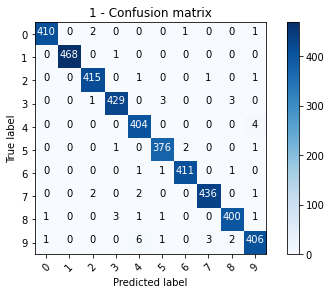

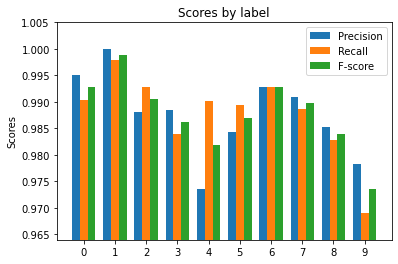

Iteration No. 2

Train on 37796 samples, validate on 4204 samples
Epoch 1/10
37760/37796 [============================>.] - ETA: 0s - loss: 4.2970 - acc: 0.9567
Epoch 00001: val_loss improved from inf to 3.56335, saving model to img_classifier_model_2_ResNet50_epoch10_batch64_ensemble.h5
37796/37796 [==============================] - 45s 1ms/sample - loss: 4.2963 - acc: 0.9567 - val_loss: 3.5633 - val_acc: 0.9774
Epoch 2/10
37760/37796 [============================>.] - ETA: 0s - loss: 3.1758 - acc: 0.9919
Epoch 00002: val_loss improved from 3.56335 to 2.92110, saving model to img_classifier_model_2_ResNet50_epoch10_batch64_ensemble.h5
37796/37796 [==============================] - 35s 920us/sample - loss: 3.1755 - acc: 0.9919 - val_loss: 2.9211 - val_acc: 0.9822
Epoch 3/10
37760/37796 [============================>.] - ETA: 0s - loss: 2.6733 - acc: 0.9977
Epoch 00003: val_loss improved from 2.92110 to 2.53097, saving model to img_classifier_model_2_ResNet50_epoch10_batch64_ensemble.h5

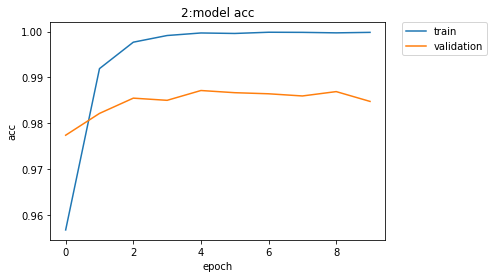

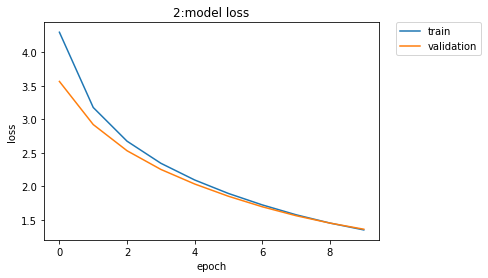

Done compiling best model.


2. Accuracy on validation data: 0.984776
Classification Report
              precision    recall  f1-score   support

           0    0.98798   0.99275   0.99036       414
           1    0.99147   0.99147   0.99147       469
           2    0.97872   0.99043   0.98454       418
           3    0.98605   0.97471   0.98035       435
           4    0.99015   0.98529   0.98771       408
           5    0.97375   0.97632   0.97503       380
           6    0.99268   0.98309   0.98786       414
           7    0.99087   0.98636   0.98861       440
           8    0.98284   0.98526   0.98405       407
           9    0.97163   0.98091   0.97625       419

   micro avg    0.98478   0.98478   0.98478      4204
   macro avg    0.98461   0.98466   0.98462      4204
weighted avg    0.98481   0.98478   0.98478      4204
 samples avg    0.98478   0.98478   0.98478      4204





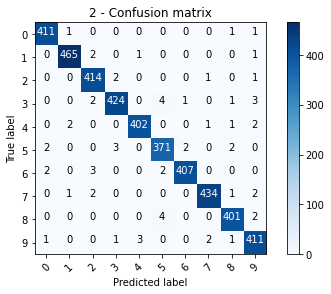

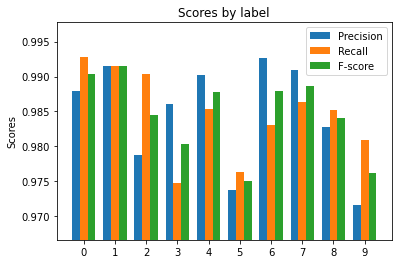

Iteration No. 3

Train on 37798 samples, validate on 4202 samples
Epoch 1/10
37760/37798 [============================>.] - ETA: 0s - loss: 4.3073 - acc: 0.9571
Epoch 00001: val_loss improved from inf to 3.57322, saving model to img_classifier_model_3_ResNet50_epoch10_batch64_ensemble.h5
37798/37798 [==============================] - 45s 1ms/sample - loss: 4.3067 - acc: 0.9571 - val_loss: 3.5732 - val_acc: 0.9812
Epoch 2/10
37760/37798 [============================>.] - ETA: 0s - loss: 3.1957 - acc: 0.9912
Epoch 00002: val_loss improved from 3.57322 to 2.92826, saving model to img_classifier_model_3_ResNet50_epoch10_batch64_ensemble.h5
37798/37798 [==============================] - 35s 923us/sample - loss: 3.1954 - acc: 0.9912 - val_loss: 2.9283 - val_acc: 0.9848
Epoch 3/10
37760/37798 [============================>.] - ETA: 0s - loss: 2.6913 - acc: 0.9980
Epoch 00003: val_loss improved from 2.92826 to 2.53645, saving model to img_classifier_model_3_ResNet50_epoch10_batch64_ensemble.h5

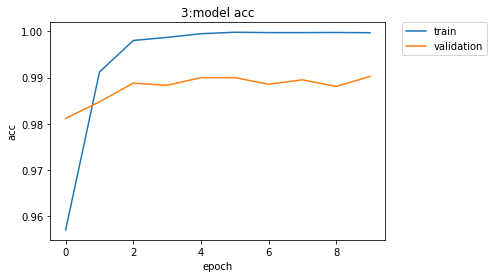

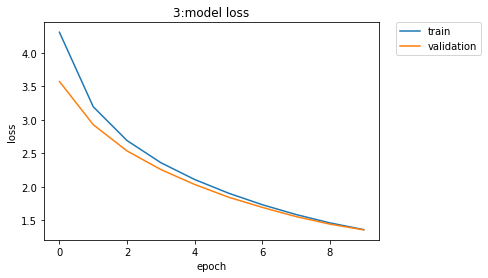

Done compiling best model.


3. Accuracy on validation data: 0.990243
Classification Report
              precision    recall  f1-score   support

           0    0.99274   0.99274   0.99274       413
           1    0.98938   0.99360   0.99149       469
           2    0.98333   0.98804   0.98568       418
           3    0.98853   0.99080   0.98967       435
           4    0.98529   0.98771   0.98650       407
           5    1.00000   0.98684   0.99338       380
           6    0.99043   1.00000   0.99519       414
           7    0.99095   0.99545   0.99320       440
           8    0.99502   0.98280   0.98888       407
           9    0.98801   0.98329   0.98565       419

   micro avg    0.99024   0.99024   0.99024      4202
   macro avg    0.99037   0.99013   0.99024      4202
weighted avg    0.99026   0.99024   0.99024      4202
 samples avg    0.99024   0.99024   0.99024      4202





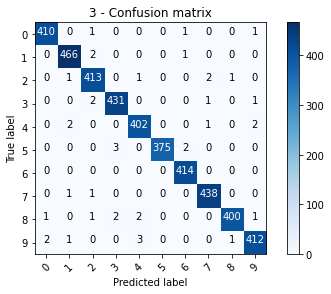

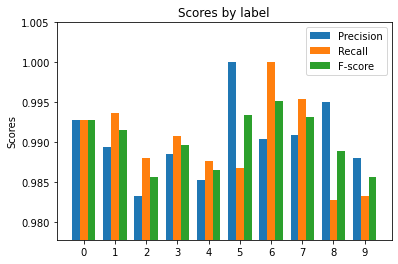

Iteration No. 4

Train on 37799 samples, validate on 4201 samples
Epoch 1/10
37760/37799 [============================>.] - ETA: 0s - loss: 4.2413 - acc: 0.9586
Epoch 00001: val_loss improved from inf to 3.50278, saving model to img_classifier_model_4_ResNet50_epoch10_batch64_ensemble.h5
37799/37799 [==============================] - 45s 1ms/sample - loss: 4.2405 - acc: 0.9586 - val_loss: 3.5028 - val_acc: 0.9762
Epoch 2/10
37760/37799 [============================>.] - ETA: 0s - loss: 3.1011 - acc: 0.9925
Epoch 00002: val_loss improved from 3.50278 to 2.85004, saving model to img_classifier_model_4_ResNet50_epoch10_batch64_ensemble.h5
37799/37799 [==============================] - 35s 926us/sample - loss: 3.1008 - acc: 0.9925 - val_loss: 2.8500 - val_acc: 0.9824
Epoch 3/10
37760/37799 [============================>.] - ETA: 0s - loss: 2.6021 - acc: 0.9965
Epoch 00003: val_loss improved from 2.85004 to 2.47726, saving model to img_classifier_model_4_ResNet50_epoch10_batch64_ensemble.h5

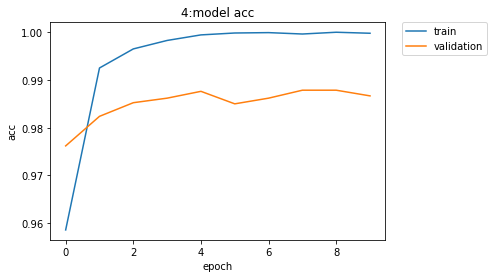

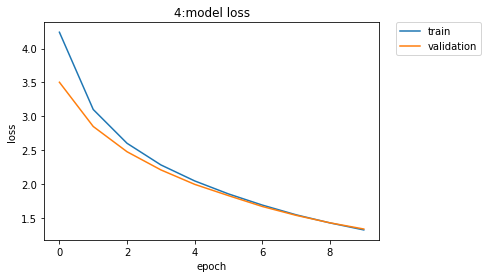

Done compiling best model.


4. Accuracy on validation data: 0.986670
Classification Report
              precision    recall  f1-score   support

           0    0.98561   0.99516   0.99036       413
           1    0.98929   0.98507   0.98718       469
           2    0.99045   0.99282   0.99164       418
           3    0.98394   0.98621   0.98507       435
           4    0.99259   0.98771   0.99015       407
           5    0.99200   0.97895   0.98543       380
           6    0.98321   0.99034   0.98676       414
           7    0.98194   0.98864   0.98528       440
           8    0.98272   0.98030   0.98150       406
           9    0.98561   0.98091   0.98325       419

   micro avg    0.98667   0.98667   0.98667      4201
   macro avg    0.98674   0.98661   0.98666      4201
weighted avg    0.98669   0.98667   0.98667      4201
 samples avg    0.98667   0.98667   0.98667      4201





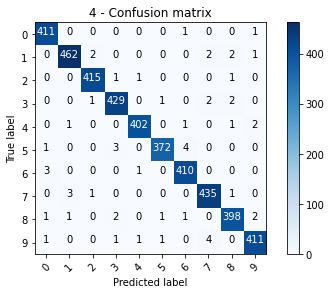

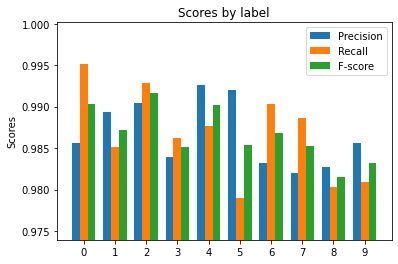

Iteration No. 5

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37760/37800 [============================>.] - ETA: 0s - loss: 4.3142 - acc: 0.9577
Epoch 00001: val_loss improved from inf to 3.60938, saving model to img_classifier_model_5_ResNet50_epoch10_batch64_ensemble.h5
37800/37800 [==============================] - 44s 1ms/sample - loss: 4.3135 - acc: 0.9577 - val_loss: 3.6094 - val_acc: 0.9762
Epoch 2/10
37760/37800 [============================>.] - ETA: 0s - loss: 3.2087 - acc: 0.9923
Epoch 00002: val_loss improved from 3.60938 to 2.96766, saving model to img_classifier_model_5_ResNet50_epoch10_batch64_ensemble.h5
37800/37800 [==============================] - 35s 921us/sample - loss: 3.2084 - acc: 0.9923 - val_loss: 2.9677 - val_acc: 0.9812
Epoch 3/10
37760/37800 [============================>.] - ETA: 0s - loss: 2.7079 - acc: 0.9974
Epoch 00003: val_loss improved from 2.96766 to 2.57948, saving model to img_classifier_model_5_ResNet50_epoch10_batch64_ensemble.h5

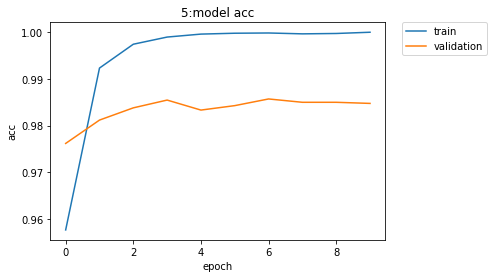

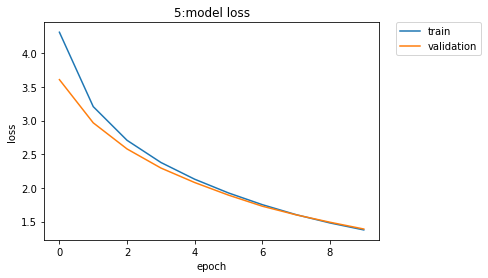

Done compiling best model.


5. Accuracy on validation data: 0.984762
Classification Report
              precision    recall  f1-score   support

           0    0.99277   0.99758   0.99517       413
           1    0.99353   0.98504   0.98927       468
           2    0.98082   0.97847   0.97964       418
           3    0.97945   0.98621   0.98282       435
           4    0.98515   0.97789   0.98150       407
           5    0.98408   0.97632   0.98018       380
           6    0.99272   0.98792   0.99031       414
           7    0.97545   0.99318   0.98423       440
           8    0.99005   0.98030   0.98515       406
           9    0.97400   0.98329   0.97862       419

   micro avg    0.98476   0.98476   0.98476      4200
   macro avg    0.98480   0.98462   0.98469      4200
weighted avg    0.98481   0.98476   0.98476      4200
 samples avg    0.98476   0.98476   0.98476      4200





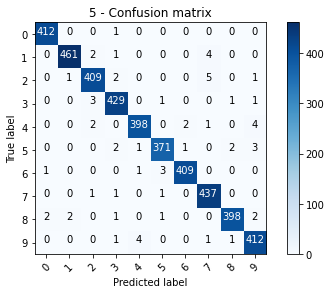

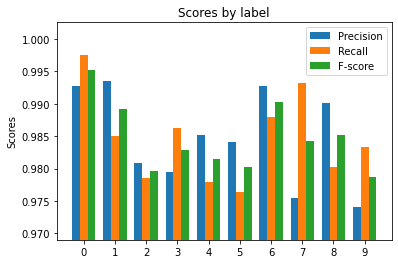

Iteration No. 6

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37760/37801 [============================>.] - ETA: 0s - loss: 4.2564 - acc: 0.9580
Epoch 00001: val_loss improved from inf to 3.51000, saving model to img_classifier_model_6_ResNet50_epoch10_batch64_ensemble.h5
37801/37801 [==============================] - 44s 1ms/sample - loss: 4.2555 - acc: 0.9580 - val_loss: 3.5100 - val_acc: 0.9798
Epoch 2/10
37760/37801 [============================>.] - ETA: 0s - loss: 3.1245 - acc: 0.9919
Epoch 00002: val_loss improved from 3.51000 to 2.87099, saving model to img_classifier_model_6_ResNet50_epoch10_batch64_ensemble.h5
37801/37801 [==============================] - 35s 927us/sample - loss: 3.1242 - acc: 0.9919 - val_loss: 2.8710 - val_acc: 0.9852
Epoch 3/10
37760/37801 [============================>.] - ETA: 0s - loss: 2.6280 - acc: 0.9974
Epoch 00003: val_loss improved from 2.87099 to 2.49476, saving model to img_classifier_model_6_ResNet50_epoch10_batch64_ensemble.h5

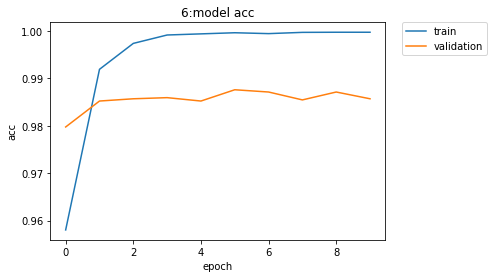

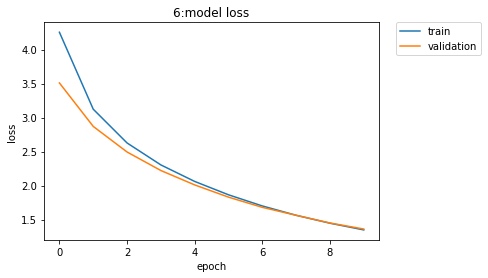

Done compiling best model.


6. Accuracy on validation data: 0.985711
Classification Report
              precision    recall  f1-score   support

           0    0.99027   0.98547   0.98786       413
           1    0.99785   0.99145   0.99464       468
           2    0.99045   0.99282   0.99164       418
           3    0.99076   0.98621   0.98848       435
           4    0.98034   0.98034   0.98034       407
           5    0.98670   0.97889   0.98278       379
           6    0.98565   0.99517   0.99038       414
           7    0.97758   0.99091   0.98420       440
           8    0.97304   0.97783   0.97543       406
           9    0.98317   0.97613   0.97964       419

   micro avg    0.98571   0.98571   0.98571      4199
   macro avg    0.98558   0.98552   0.98554      4199
weighted avg    0.98574   0.98571   0.98571      4199
 samples avg    0.98571   0.98571   0.98571      4199





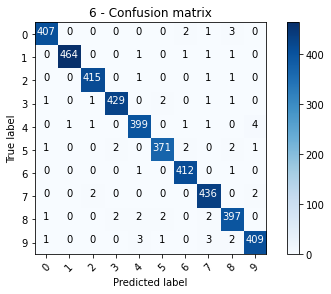

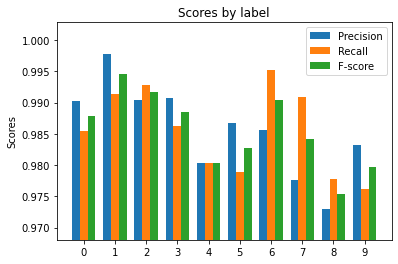

Iteration No. 7

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37760/37801 [============================>.] - ETA: 0s - loss: 4.2865 - acc: 0.9564
Epoch 00001: val_loss improved from inf to 3.53559, saving model to img_classifier_model_7_ResNet50_epoch10_batch64_ensemble.h5
37801/37801 [==============================] - 44s 1ms/sample - loss: 4.2859 - acc: 0.9564 - val_loss: 3.5356 - val_acc: 0.9831
Epoch 2/10
37760/37801 [============================>.] - ETA: 0s - loss: 3.1577 - acc: 0.9919
Epoch 00002: val_loss improved from 3.53559 to 2.88721, saving model to img_classifier_model_7_ResNet50_epoch10_batch64_ensemble.h5
37801/37801 [==============================] - 35s 922us/sample - loss: 3.1574 - acc: 0.9920 - val_loss: 2.8872 - val_acc: 0.9883
Epoch 3/10
37760/37801 [============================>.] - ETA: 0s - loss: 2.6545 - acc: 0.9975
Epoch 00003: val_loss improved from 2.88721 to 2.50336, saving model to img_classifier_model_7_ResNet50_epoch10_batch64_ensemble.h5

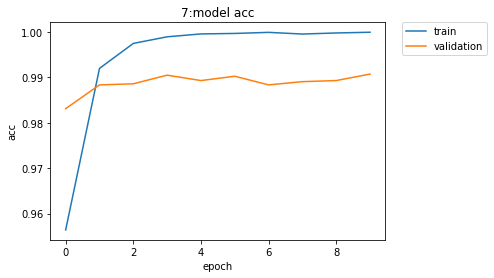

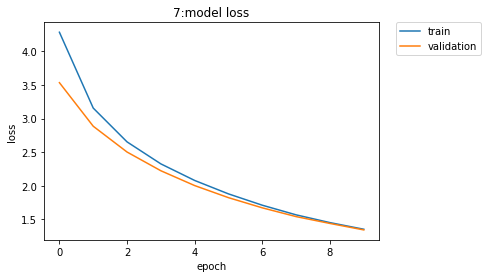

Done compiling best model.


7. Accuracy on validation data: 0.990712
Classification Report
              precision    recall  f1-score   support

           0    0.99029   0.98789   0.98909       413
           1    0.99360   0.99573   0.99466       468
           2    0.99518   0.98804   0.99160       418
           3    0.99312   0.99540   0.99426       435
           4    0.99510   0.99754   0.99632       407
           5    0.98681   0.98681   0.98681       379
           6    0.98792   0.98792   0.98792       414
           7    0.99095   0.99545   0.99320       440
           8    0.98054   0.99261   0.98654       406
           9    0.99274   0.97852   0.98558       419

   micro avg    0.99071   0.99071   0.99071      4199
   macro avg    0.99062   0.99059   0.99060      4199
weighted avg    0.99073   0.99071   0.99071      4199
 samples avg    0.99071   0.99071   0.99071      4199





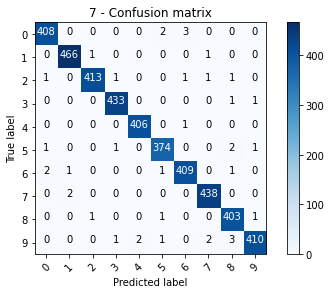

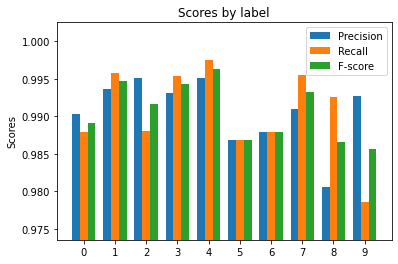

Iteration No. 8

Train on 37803 samples, validate on 4197 samples
Epoch 1/10
37760/37803 [============================>.] - ETA: 0s - loss: 4.2397 - acc: 0.9564
Epoch 00001: val_loss improved from inf to 3.47507, saving model to img_classifier_model_8_ResNet50_epoch10_batch64_ensemble.h5
37803/37803 [==============================] - 45s 1ms/sample - loss: 4.2388 - acc: 0.9565 - val_loss: 3.4751 - val_acc: 0.9836
Epoch 2/10
37760/37803 [============================>.] - ETA: 0s - loss: 3.1034 - acc: 0.9912
Epoch 00002: val_loss improved from 3.47507 to 2.84582, saving model to img_classifier_model_8_ResNet50_epoch10_batch64_ensemble.h5
37803/37803 [==============================] - 35s 923us/sample - loss: 3.1031 - acc: 0.9912 - val_loss: 2.8458 - val_acc: 0.9845
Epoch 3/10
37760/37803 [============================>.] - ETA: 0s - loss: 2.6096 - acc: 0.9977
Epoch 00003: val_loss improved from 2.84582 to 2.46585, saving model to img_classifier_model_8_ResNet50_epoch10_batch64_ensemble.h5

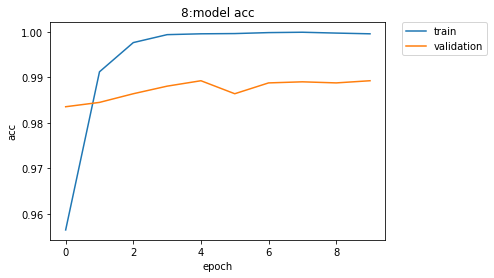

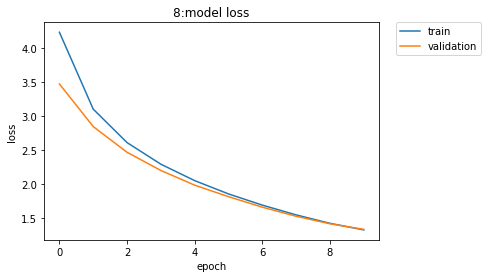

Done compiling best model.


8. Accuracy on validation data: 0.989278
Classification Report
              precision    recall  f1-score   support

           0    0.98554   0.99031   0.98792       413
           1    0.99574   1.00000   0.99787       468
           2    0.99519   0.99281   0.99400       417
           3    0.99533   0.97931   0.98725       435
           4    0.99259   0.98771   0.99015       407
           5    0.98168   0.98945   0.98555       379
           6    0.99513   0.99031   0.99272       413
           7    0.99091   0.99091   0.99091       440
           8    0.97115   0.99507   0.98297       406
           9    0.98792   0.97613   0.98199       419

   micro avg    0.98928   0.98928   0.98928      4197
   macro avg    0.98912   0.98920   0.98913      4197
weighted avg    0.98934   0.98928   0.98928      4197
 samples avg    0.98928   0.98928   0.98928      4197





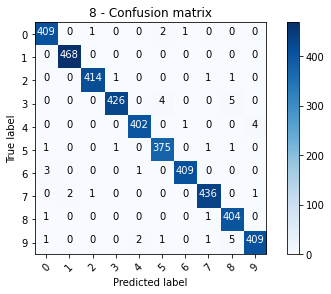

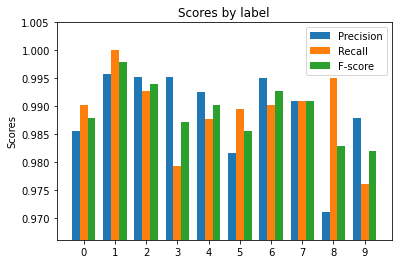

Iteration No. 9

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37760/37804 [============================>.] - ETA: 0s - loss: 4.2958 - acc: 0.9564
Epoch 00001: val_loss improved from inf to 3.55242, saving model to img_classifier_model_9_ResNet50_epoch10_batch64_ensemble.h5
37804/37804 [==============================] - 44s 1ms/sample - loss: 4.2950 - acc: 0.9564 - val_loss: 3.5524 - val_acc: 0.9828
Epoch 2/10
37760/37804 [============================>.] - ETA: 0s - loss: 3.1692 - acc: 0.9919
Epoch 00002: val_loss improved from 3.55242 to 2.90522, saving model to img_classifier_model_9_ResNet50_epoch10_batch64_ensemble.h5
37804/37804 [==============================] - 35s 925us/sample - loss: 3.1689 - acc: 0.9919 - val_loss: 2.9052 - val_acc: 0.9871
Epoch 3/10
37760/37804 [============================>.] - ETA: 0s - loss: 2.6655 - acc: 0.9979
Epoch 00003: val_loss improved from 2.90522 to 2.51950, saving model to img_classifier_model_9_ResNet50_epoch10_batch64_ensemble.h5

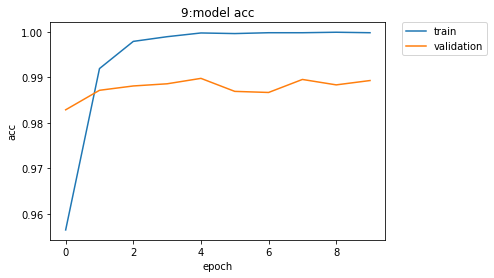

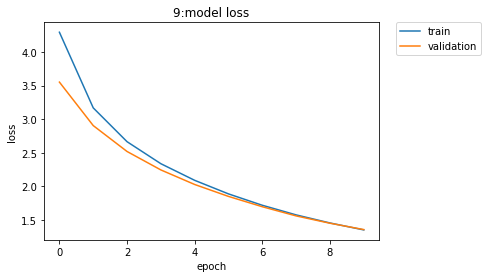

Done compiling best model.


9. Accuracy on validation data: 0.989276
Classification Report
              precision    recall  f1-score   support

           0    0.98798   0.99516   0.99156       413
           1    0.98732   0.99786   0.99256       468
           2    0.98795   0.98321   0.98558       417
           3    0.99078   0.98851   0.98964       435
           4    0.98778   0.99263   0.99020       407
           5    0.98950   0.99472   0.99211       379
           6    0.99515   0.99274   0.99394       413
           7    0.99089   0.98864   0.98976       440
           8    0.99002   0.97783   0.98389       406
           9    0.98558   0.98086   0.98321       418

   micro avg    0.98928   0.98928   0.98928      4196
   macro avg    0.98929   0.98922   0.98924      4196
weighted avg    0.98928   0.98928   0.98927      4196
 samples avg    0.98928   0.98928   0.98928      4196





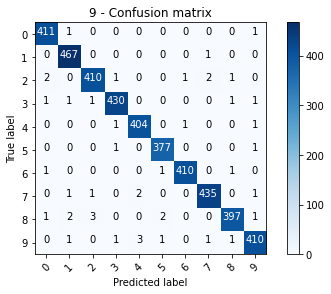

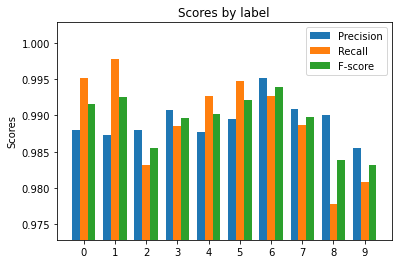

Iteration No. 10

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37760/37804 [============================>.] - ETA: 0s - loss: 4.2305 - acc: 0.9584
Epoch 00001: val_loss improved from inf to 3.47766, saving model to img_classifier_model_10_ResNet50_epoch10_batch64_ensemble.h5
37804/37804 [==============================] - 44s 1ms/sample - loss: 4.2296 - acc: 0.9584 - val_loss: 3.4777 - val_acc: 0.9805
Epoch 2/10
37760/37804 [============================>.] - ETA: 0s - loss: 3.0821 - acc: 0.9920
Epoch 00002: val_loss improved from 3.47766 to 2.82754, saving model to img_classifier_model_10_ResNet50_epoch10_batch64_ensemble.h5
37804/37804 [==============================] - 35s 923us/sample - loss: 3.0817 - acc: 0.9920 - val_loss: 2.8275 - val_acc: 0.9847
Epoch 3/10
37760/37804 [============================>.] - ETA: 0s - loss: 2.5804 - acc: 0.9968
Epoch 00003: val_loss improved from 2.82754 to 2.44016, saving model to img_classifier_model_10_ResNet50_epoch10_batch64_ensembl

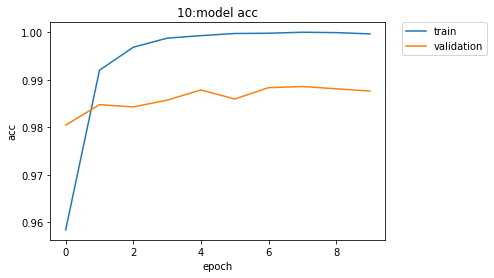

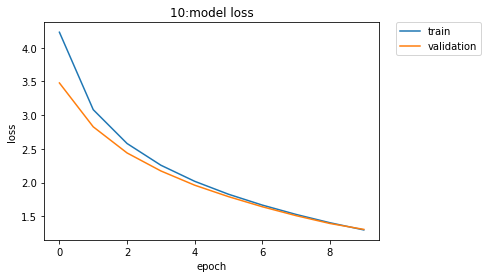

Done compiling best model.


10. Accuracy on validation data: 0.987607
Classification Report
              precision    recall  f1-score   support

           0    0.99754   0.98305   0.99024       413
           1    0.99572   0.99359   0.99465       468
           2    0.98337   0.99281   0.98807       417
           3    0.99304   0.98391   0.98845       435
           4    0.98519   0.98034   0.98276       407
           5    0.99202   0.98417   0.98808       379
           6    0.98804   1.00000   0.99398       413
           7    0.98413   0.98636   0.98524       440
           8    0.98762   0.98276   0.98519       406
           9    0.96948   0.98804   0.97867       418

   micro avg    0.98761   0.98761   0.98761      4196
   macro avg    0.98762   0.98750   0.98753      4196
weighted avg    0.98767   0.98761   0.98761      4196
 samples avg    0.98761   0.98761   0.98761      4196





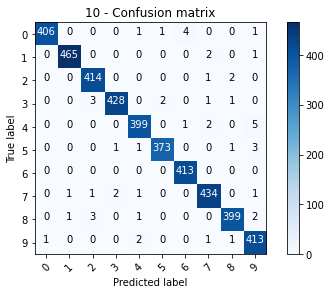

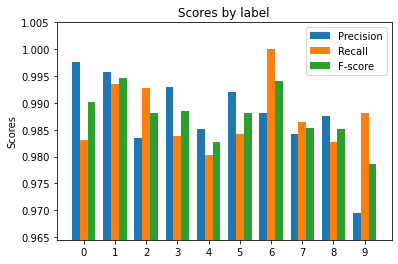

In [6]:
# ラベルの分布比率を維持した無作為抽出で10分割の交差検証を行う．シードは0で固定
skf = StratifiedKFold(n_splits=sp, shuffle = True, random_state = 0) 

for i, (train_idx, val_idx) in enumerate(skf.split(train, label_num)):
    # train(90%) / validation(10%) に分割
    X_train = train[train_idx]
    Y_train = label[train_idx]
    X_val = train[val_idx]
    Y_val = label[val_idx]
    
    # 分割ごとにモデルを初期化
    momentum = Adam(lr=learning_rate, decay=0.01)
    ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50
    ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

    # 学習を開始
    print("Iteration No. %d\n" %(i+1))
    
    # モデル読み込み時に使用するファイル
    model_file = 'img_classifier_model_%s_%s.h5' %(i+1, model_name)
    
    # 学習時に使用するコールバック
    def model_callbacks():
        # 各エポックでval_lossを監視し，最小値を更新した場合にモデルの重みを保存
        checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        # early_stopping_patience回連続でval_loss下がらなければ，学習打ち止め
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')

        return [checkpoint, early_stopping]

    callbacks_list = model_callbacks()
    
    # モデルのフィッティング
    history = ResNetModel.fit(X_train, 
                              Y_train, 
                              batch_size=batch_size, 
                              epochs=n_epoch,
                              verbose=1,
                              shuffle=True,
                              validation_data=(X_val, Y_val),
                              callbacks=callbacks_list)
    
    # 学習曲線の可視化
    def visualise_curve(model, monitor, itr):
        plt.figure()
        plt.plot(model.history[monitor])
        # validationも可視化する場合
        if isinstance(itr, int):
            plt.plot(model.history["val_"+ monitor])
        plt.title(str(itr)+":model "+ monitor)
        plt.ylabel(monitor)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        plt.savefig(csv_dir+"/"+str(itr)+" - "+monitor+".png", bbox_inches="tight")
        plt.show()
            
    visualise_curve(history, "acc", i+1) # accuracyに関して表示
    visualise_curve(history, "loss", i+1) # lossに関して表示
    
    # 最良のモデルでvalidationデータの性能評価
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    plt.close("all")
    print("Done compiling best model.\n\n")
    
    # validationデータの予測
    predict[val_idx] = loaded_model.predict(X_val) # 各ラベルである確率
    predict_label[val_idx] = np_utils.to_categorical(np.argmax(predict[val_idx], axis=1), n_classes) # one-hot encoding
    
    # accuracyの表示
    print("%d. Accuracy on validation data: %f" %(i+1, accuracy_score(Y_val, predict_label[val_idx])))
    acc_str = str(i+1)+". Accuracy on validation data: "+ str(accuracy_score(Y_val, predict_label[val_idx]))+"\n\n"
    acc_list[i] = accuracy_score(Y_val, predict_label[val_idx])

    # その他の評価指標の表示と結果の保存
    print("Classification Report")
    report = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5)+"\n\n"
    report_file=open(csv_dir + "/report_" + model_name + ".txt","a")
    report_file.write(acc_str + report)
    report_file.close()
    print(report)
    other_score = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5, output_dict=True)
    
    for j in range(n_classes):
        precision_list[i,j] = other_score[str(j)]["precision"]
        recall_list[i,j] = other_score[str(j)]["recall"]
        fscore_list[i,j] = other_score[str(j)]["f1-score"]
        
    avg_precision[i] = other_score["macro avg"]["precision"]
    avg_recall[i] = other_score["macro avg"]["recall"]
    avg_fscore[i] = other_score["macro avg"]["f1-score"]

    # 混合行列の計算
    np.set_printoptions(precision=2)
    cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(predict[val_idx], axis=1))

    # 混合行列の描画と保存
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize: # パーセント表記にしたい場合
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            filename = title + "_normalized.png"
        else: # 実際のデータ数で表示したい場合
            filename = title + "_nonnorm.png"

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(conf_dir + "/" + filename, bbox_inches="tight")
        plt.show()

    plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title=str(i+1)+" - Confusion matrix")
    
    # 各ラベルの精度に関してグラフ化
    def plot_scores(precision, recall, fscore, title):
        x = np.arange(len(class_names)) * 2 # ラベルの位置
        width = 0.5 # バーの横幅

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width, precision, width, label="Precision")
        rects2 = ax.bar(x, recall, width, label="Recall")
        rects3 = ax.bar(x + width, fscore, width, label="F-score")
        ylim_min = np.min([precision, recall, fscore]) - 0.005
        ylim_max = np.max([precision, recall, fscore]) + 0.005

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by label')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names)
        ax.set_ylim(ylim_min, ylim_max)
        ax.legend()

        plt.savefig(csv_dir + "/" + title)
        plt.show()
    
    plot_scores(precision_list[i], recall_list[i], fscore_list[i], title = str(i+1)+ " - Score.png")
    
    # 各交差検証の終わりに不要なデータを破棄
    clear_session()
    del ResNetModel, loaded_model, history, X_train, X_val, Y_train, Y_val
    gc.collect()
    
#clear_output()

# move h5 file
if "ensemble" in model_name:
    for i in glob.glob("*model*"+model_name+"*"+"h5"):
        shutil.move(i, model_dir)

# モデルファイルの削除
for i in glob.glob("*"+model_name+"*"):
    os.remove(i)

### 4.2.2 Total Results Report

Accuracy on all validarion data: 0.987690
Classification Report
              precision    recall  f1-score   support

           0    0.99057   0.99105   0.99081      4132
           1    0.99338   0.99317   0.99327      4684
           2    0.98734   0.98923   0.98828      4177
           3    0.98893   0.98552   0.98722      4351
           4    0.98674   0.98674   0.98674      4072
           5    0.98705   0.98419   0.98562      3795
           6    0.99035   0.99202   0.99118      4137
           7    0.98642   0.99046   0.98844      4401
           8    0.98376   0.98376   0.98376      4063
           9    0.98158   0.97970   0.98064      4188

   micro avg    0.98769   0.98769   0.98769     42000
   macro avg    0.98761   0.98758   0.98760     42000
weighted avg    0.98769   0.98769   0.98769     42000
 samples avg    0.98769   0.98769   0.98769     42000





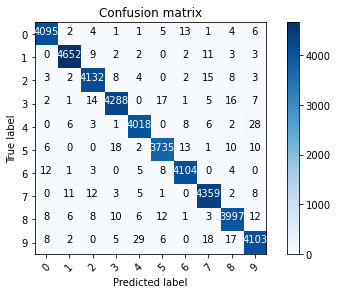

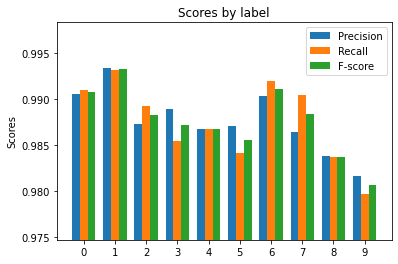

In [7]:
# 交差検証の結果の集計
plt.close('all')

# accuracyの表示
print('Accuracy on all validarion data: %f' %accuracy_score(label, predict_label))
acc_str = "Accuracy on all validarion data: "+ str(accuracy_score(label, predict_label))+"\n\n"

print('Classification Report')
report = classification_report(label, predict_label, target_names = class_names, digits = 5)+"\n\n"
report_file=open(csv_dir+"/report_"+ model_name + ".txt","a")
report_file.write(acc_str + report)
report_file.close()
print(report)

# 混合行列の計算
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(predict_label, axis=1))

# 混合行列の描画と保存
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title='Confusion matrix')

# 各交差検証の評価値を集計
score_table = pd.DataFrame(index = list(range(1,sp+1)))
score_table["Accuracy"] = acc_list
score_table["avg_Precision"] = avg_precision
score_table["avg_Recall"] = avg_recall
score_table["avg_F-score"] = avg_fscore

for i in range(n_classes):
    score_table[str(i) + "_Precision"] = precision_list[:, i]
    score_table[str(i) + "_Recall"] = recall_list[:, i]    
    score_table[str(i) + "_F-score"] = fscore_list[:, i]    
    
# 平均と標準偏差を計算して追加
avg = pd.Series(score_table.mean(),name="Avg")
std = pd.Series(score_table.std(),name="Std")

# 資料等に乗せるために整形したものも追加　(平均精度を % 表記，括弧内に標準偏差)
sr = []
for col in score_table.columns:
    sr.append(str(round(avg[col]*100,1))+"("+str(round(std[col]*100,1))+")%")
    
sr = pd.Series(sr, index=score_table.columns, name="sr")

# 追加データを結合
score_table = score_table.append(avg)
score_table = score_table.append(std)
score_table = score_table.append(sr)

# 結果ファイルを出力
score_table.to_csv(csv_dir+"/Result_"+model_name+".csv")

# 各ラベルの精度に関してグラフ化
plot_scores(avg[4:35:3], avg[5:35:3], avg[6:35:3], title = "Score.png")

### 4.2.3 Error data results

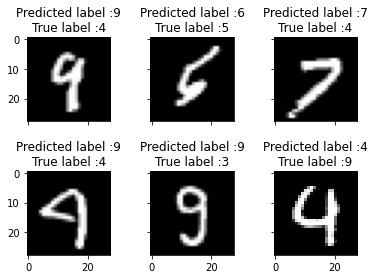

In [8]:
# 間違って推測したラベルの予測値と正しいラベルの予測値の差が大きいデータを上位6枚表示
predict_label_num = np.argmax(predict, axis=1) # 予測されたクラス名
errors = (predict_label_num - label_num != 0) # 間違ったデータはTrue

pred_classes_errors = predict_label_num[errors] # エラーデータの予測されたクラス名を抽出
pred_errors = predict[errors] # エラーデータの各クラスの予測値
true_errors = label_num[errors] # エラーデータの正しいクラス名
val_errors = train[errors] # エラーデータ（画像）

# 予測ラベルと正解ラベルを表記して，エラーデータを表示する関数
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    # 余白を設定
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.savefig(csv_dir + "/" + "Error.png")

# エラーデータが間違って予測されたクラスの予測値を抽出
pred_errors_prob = np.max(pred_errors,axis = 1)

# エラーデータの正しいクラスの予測値を抽出
true_prob_errors = np.diagonal(np.take(pred_errors, true_errors, axis=1))

# 予測されたクラスと正しいクラスの予測値の差
delta_pred_true_errors = pred_errors_prob - true_prob_errors

# delta_pred_true_errorsを小さい順にソートした時のインデックスを抽出
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 正解ラベルとの予測値の差が大きいデータのインデックスを上位6個抽出
most_important_errors = sorted_dela_errors[-6:]

# 表示
display_errors(most_important_errors, val_errors, pred_classes_errors, true_errors)

# 5. All data training and test

## 5.1 Training

Train on 42000 samples
Epoch 1/10
42000/42000 [==============================] - 45s 1ms/sample - loss: 4.2090 - acc: 0.9620
Epoch 2/10
42000/42000 [==============================] - 37s 877us/sample - loss: 3.0721 - acc: 0.9929
Epoch 3/10
42000/42000 [==============================] - 37s 880us/sample - loss: 2.5730 - acc: 0.9979
Epoch 4/10
42000/42000 [==============================] - 37s 880us/sample - loss: 2.2494 - acc: 0.9989
Epoch 5/10
42000/42000 [==============================] - 37s 880us/sample - loss: 2.0050 - acc: 0.9996
Epoch 6/10
42000/42000 [==============================] - 37s 883us/sample - loss: 1.8068 - acc: 0.9998
Epoch 7/10
42000/42000 [==============================] - 37s 887us/sample - loss: 1.6443 - acc: 0.9996
Epoch 8/10
42000/42000 [==============================] - 37s 889us/sample - loss: 1.5124 - acc: 0.9996
Epoch 9/10
42000/42000 [==============================] - 37s 887us/sample - loss: 1.4043 - acc: 0.9999
Epoch 10/10
42000/42000 [==================

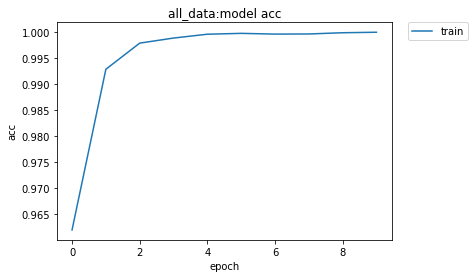

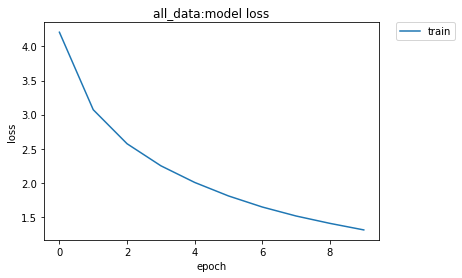

In [9]:
# モデルの初期化
momentum = Adam(lr=learning_rate, decay=0.01)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes)
ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

# モデルのフィッティング
history = ResNetModel.fit(train, label, batch_size=batch_size, epochs=n_epoch, verbose=1, shuffle=True)

# 学習曲線の可視化
visualise_curve(history, "acc", "all_data") # accuracyに関して表示
visualise_curve(history, "loss", "all_data") # lossに関して表示

## 5.2 Test

In [10]:
# testデータの予測
test_predict = ResNetModel.predict(test) # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result1.csv", index = False)

# モデルの破棄
clear_session()
del ResNetModel, history
gc.collect()

514797

# 6. Ensemble model test

In [11]:
# 各バリデーションモデルの予測値の平均
test_predict = np.zeros((len(test), n_classes))
for model_file in glob.glob(model_dir+"/*"):
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    test_predict += loaded_model.predict(test)
    # モデルの破棄
    clear_session()
    del loaded_model
    gc.collect()

test_predict /= n_classes # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result2.csv", index = False)